In [1]:
from models import UNet, FCN
from utils import entropy_loss, dice_loss
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import time
import tqdm


model_name = 'fcn'
loss_function = entropy_loss

x_train_path = './Dataset/sample_train_color/'
t_train_path = './Dataset/sample_train_label/'
x_train_name = os.listdir(x_train_path)
t_train_name = os.listdir(t_train_path)
x_train_name = [x_train_path+s for s in x_train_name]
x_train_name = x_train_name[0:100]
x_train_name.sort()
t_train_name = [t_train_path+s for s in t_train_name]
t_train_name = t_train_name[0:100]
t_train_name.sort()

# parameters
batch_size = 32
LR         = 1e-5
img_height = 90
img_width  = 422
down_scale = 8
class_num  = 9
data_size  = len(x_train_name)
n_batches  = int(math.ceil(data_size/batch_size))


# This cell is used to construct the pipeline of dataset
def _parse_function(x_name, t_name, img_shape, down_scale):
    x_string = tf.read_file(x_name)
    x = tf.image.decode_jpeg(x_string, channels=3)
    x = x[1560:2280, 7:-7]/1000
    x = tf.image.resize_images(x, img_shape)
    t_string = tf.read_file(t_name)
    t = tf.image.decode_png(t_string, channels=1, dtype=tf.uint16)
    t = t[1560:2280, 7:-7]
    t = t[::down_scale, ::down_scale]
    t = tf.cast(t/1000, tf.int32)
    
    shape = tf.shape(t)
    t = tf.reshape(t, (shape[0]*shape[1],))
    t = tf.one_hot(t, depth=41)
    t = tf.concat([t[:, 0:1], t[:, 33:]], axis=1)
    t = tf.reshape(t, (shape[0], shape[1], 9))
    
    return x, t

x_filenames = tf.constant(x_train_name)
t_filenames = tf.constant(t_train_name)

dataset = tf.data.Dataset.from_tensor_slices((x_filenames, t_filenames))
dataset = dataset.map(lambda x, y: _parse_function(x, y, (img_height, img_width), down_scale))
dataset = dataset.batch(batch_size).repeat(1)
iterator = dataset.make_initializable_iterator()
next_batch = iterator.get_next()

x_batch, t_batch = next_batch # get the tf variable of input and target images


if model_name.lower()=='unet' or model_name.lower=='u-net':
    segnet = UNet(x=x_batch, t=t_batch,
                  LR=1e-8, input_shape=[None, img_height, img_width, 3], 
                  output_shape=[None, img_height, img_width, class_num], )
    segnet.optimize(loss_function)
elif model_name.lower()=='fcn':
    segnet = FCN(x=x_batch, t=t_batch,
                  LR=1e-8, input_shape=[None, img_height, img_width, 3], 
                  output_shape=[None, img_height, img_width, class_num], )
    segnet.optimize(loss_function)


sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(iterator.initializer)

saver = tf.train.Saver()
saver.restore(sess, './Models/FCN/FCN-end/FCN.ckpt')
#saver.restore(sess, './Models/U-Net/unet-29/unet.ckpt')

INFO:tensorflow:Restoring parameters from ./Models/FCN/FCN-end/FCN.ckpt


In [2]:
y_train = []
for _ in tqdm.tqdm(range(n_batches)):
    y = sess.run(segnet.y)
    y_train += [y]
y_train = np.concatenate(y_train, axis=0)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [04:14<00:00, 61.70s/it]


In [3]:
tmp = np.argmax(y_train, axis=3)
b, h, w = tmp.shape
tmp = np.reshape(tmp, [b*h*w, 1])

def indices_to_one_hot(data, nb_classes):
    """Convert an iterable of indices to one-hot encoded labels."""
    targets = np.array(data).reshape(-1)
    return np.eye(nb_classes)[targets]

tmp = indices_to_one_hot(tmp, 9)
tmp = np.reshape(tmp, [b, h, w, 9])
print(tmp.shape)

(100, 90, 422, 9)


In [4]:
print(tmp[0, :, :, 0])

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


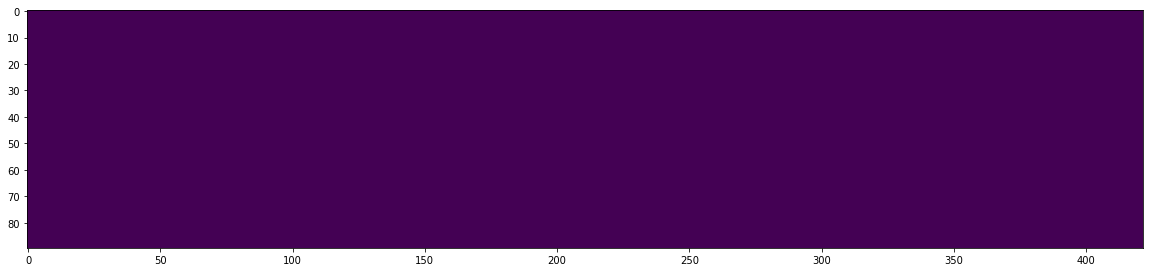

In [5]:
plt.figure(figsize=(20, 15))
plt.imshow(tmp[3, :, :, 0])
plt.show()